In [1]:
# Imports
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, einsum
import torch.nn.functional as F
from scipy.stats import norm

In [2]:
# For reproducible results
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## Task 1 - 1D diffusion process

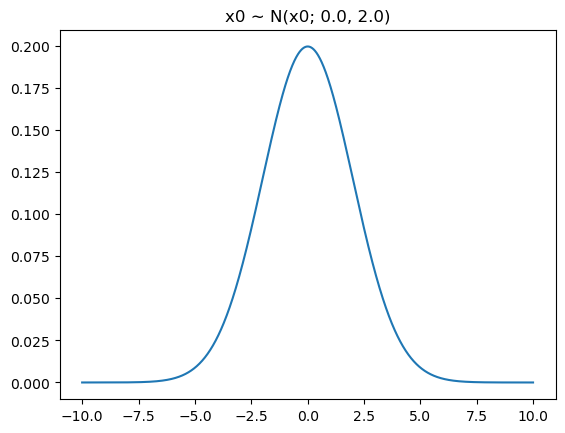

In [3]:
# x0 ∼ N(x0; m, p)
m = 0.0
p = 2.0

# Plot distribution of x0
x_axis = np.arange(-10, 10, 0.01)
plt.title(f"x0 ∼ N(x0; {m}, {p})")
plt.plot(x_axis, norm.pdf(x_axis, m, p))
plt.show()

In [4]:
# Iteratively runs forward diffusion on x0 for T timesteps
# returns: [x1, ... ,xT]
def forward_diffuse(x0, T):
    xts = []
    Bt = 0.25
    xt_prev = x0
    for i in range(T):
        ut = np.sqrt(1 - Bt) * xt_prev
        sigmat = Bt                        # Bt*I = Bt*1 in the one dimensional case
        xt = np.random.normal(ut, sigmat)  # Using formula (1) from the project description
        xts.append(xt)
        xt_prev = xt
    return xts

In [5]:
# Uses closed formula to instantly compute xT from x0
# returns: xT
def forward_diffuse_closed(x0, T):
    Bt = 0.25
    at = 1 - Bt
    at_prod = np.power(at, T)
    uT = np.sqrt(at_prod) * x0
    sigmaT = 1 - at_prod
    return np.random.normal(uT, sigmaT)

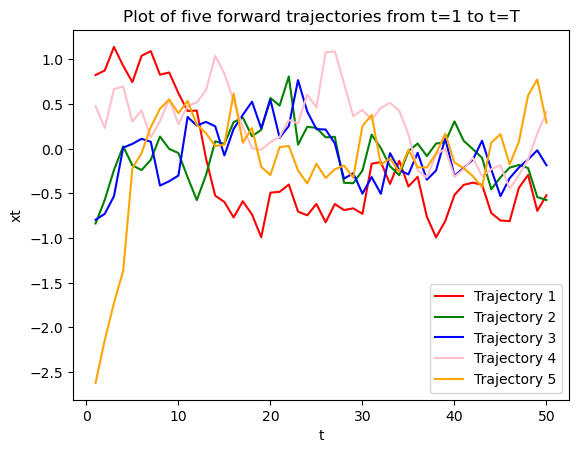

In [6]:
# Visualizing a few forward trajectories
T = 50
ts = range(1, 51)
colors = ['red', 'green', 'blue', 'pink', 'orange']
for i in range(5):
    x0 = np.random.normal(m, p)
    xts = forward_diffuse(x0, T)
    plt.plot(ts, xts, color=colors[i], label=f"Trajectory {i+1}")
plt.legend()
plt.xlabel('t')
plt.ylabel('xt')
plt.title('Plot of five forward trajectories from t=1 to t=T')   # TODO: should it not be from 0 to T?
plt.show()

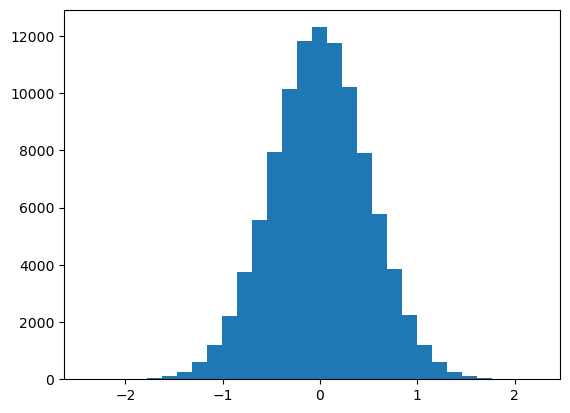

In [7]:
# Visualize the distrubution of xT, approximated from n trajectories
n = 100000    # more samples => better approximation => use effective diffusion function
xTs = []
for i in range(n):
    x0 = np.random.normal(m, p)
    xT = forward_diffuse(x0, T)[-1]
    xTs.append(xT)

plt.hist(xTs, 30)
plt.show()

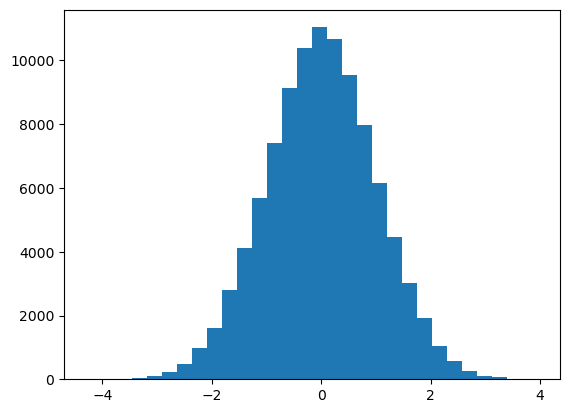

In [8]:
xTs = []
for i in range(n):
    x0 = np.random.normal(m, p)
    xT = forward_diffuse_closed(x0, T)
    xTs.append(xT)

plt.hist(xTs, 30)
plt.show()          # TODO: Why do we have double the variance here? closed and iterative formula do not agree!